# Day 19

## Set Up

In [41]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create database connection
conn = sqlite3.connect('../../data/db/database.db')

## Get the data
2022 QB performances with at least 15 attempts

In [20]:
query = """
WITH data AS (
    SELECT
        season,
        week,
        ABS(result) AS win_margin,
        total AS total_pts,
        overtime AS ot_flag
    FROM schedules 
    WHERE week <= 9
        AND game_type = 'REG'
)
SELECT *
FROM data
"""

df = pd.read_sql(query, conn)
df.head()

,season,week,win_margin,total_pts,ot_flag
0,1999,1,3.0,31.0,0.0
1,1999,1,3.0,37.0,0.0
2,1999,1,43.0,43.0,0.0
3,1999,1,4.0,52.0,0.0
4,1999,1,17.0,45.0,0.0


<AxesSubplot: xlabel='total_pts', ylabel='Count'>

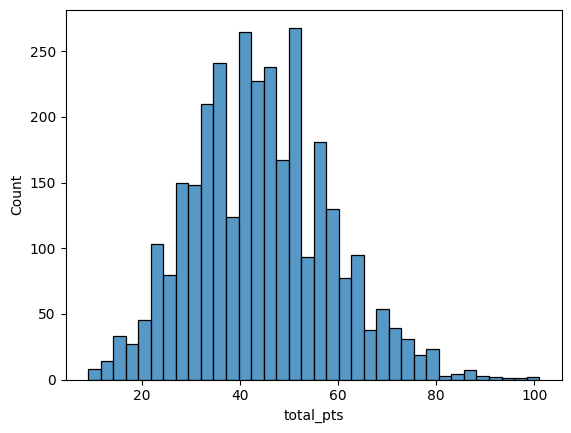

In [34]:
sns.histplot(
    x='total_pts',
    data=df,
)

<AxesSubplot: xlabel='week', ylabel='win_margin'>

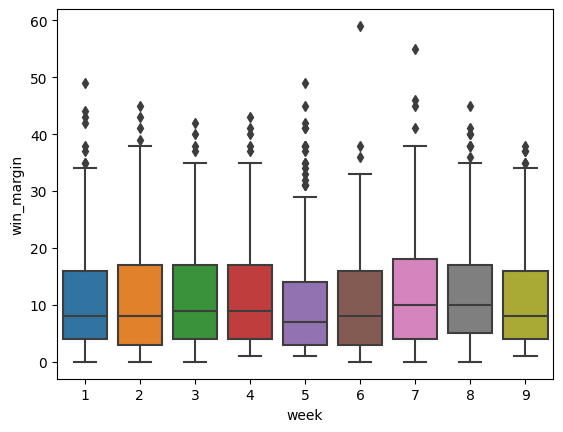

In [23]:
sns.boxplot(
    x='week',
    y='win_margin',
    data=df
)

In [24]:
by_season = df.groupby('season').mean()

<AxesSubplot: xlabel='total_pts', ylabel='Count'>

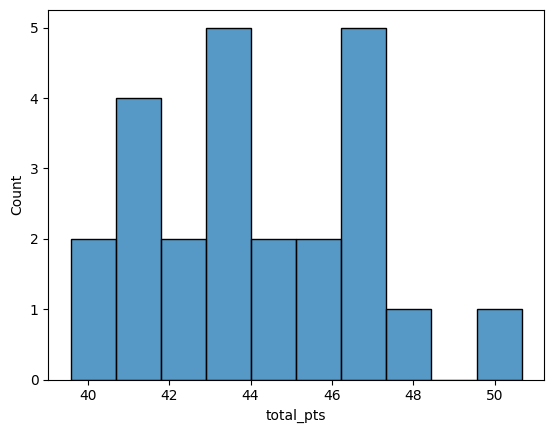

In [35]:
sns.histplot(
    x='total_pts',
    data=by_season,
    bins=10
)

In [39]:
by_season.sort_values('win_margin', ascending=False).round(2)

,week,win_margin,total_pts,ot_flag
season,,,,
2009,4.79,13.52,43.64,0.05
2014,4.89,12.73,46.81,0.06
2007,4.83,12.21,42.61,0.05
2008,4.89,12.01,44.21,0.07
2003,4.89,11.85,41.57,0.10
2006,4.87,11.70,41.26,0.04
2005,4.89,11.65,41.25,0.04
2017,4.84,11.63,43.90,0.06
2011,4.80,11.61,44.58,0.04


In [40]:
by_season.describe()

,week,win_margin,total_pts,ot_flag
count,24.000000,24.000000,24.000000,24.000000
mean,4.865124,11.344781,44.195467,0.061809
std,0.047904,0.867036,2.689436,0.023608
min,4.790698,9.426471,39.585938,0.023438
25%,4.829844,11.049069,41.961538,0.043600
50%,4.858718,11.294531,43.885373,0.059263
75%,4.892308,11.664213,46.417293,0.076349
max,4.984375,13.519380,50.654135,0.106061


In [45]:
from scipy import stats

by_season['win_margin'].quantile(0.25) - (1.5 * stats.iqr(by_season['win_margin']))

10.12635216346154

Based on this the win margin for 2022 is an outlier. At an average of 9.42 points over the first 9 weeks, it's less than the threshold of 1.5 * IQR which is 10.12 pts.

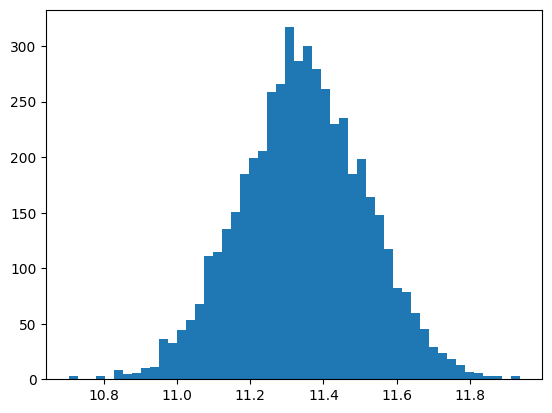

In [46]:
# Repeat steps 1 & 2 many times, appending to a list of sample means
win_margin_boot_dist = []
for i in range(5000):
	win_margin_boot_dist.append(
		# Step 2: Calculate point estimate
		np.mean(
			# Step 1: Resample
			by_season.sample(frac=1, replace=True)['win_margin']
		)
	)

# Confirm sample means are normally distributed
import matplotlib.pyplot as plt
plt.hist(win_margin_boot_dist, bins=50)
plt.show()

In [55]:
import pingouin

pingouin.ttest(win_margin_boot_dist, by_season['win_margin'], "left")

/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/pingouin/parametric.py:227: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.002333,23.008678,two-sided,0.998159,"[-0.37, 0.37]",0.002278,0.215,0.050014


## Is the average margin of victory through the first 9 weeks of 2022 different than the historical average?

In [58]:
query = """
WITH data AS (
    SELECT
        season,
        week,
        ABS(result) AS win_margin,
        total AS total_pts,
        overtime AS ot_flag
    FROM schedules 
    WHERE week <= 9
        AND game_type = 'REG'
), aggregation AS (
    SELECT season, AVG(win_margin) AS avg_win_margin
    FROM data
    GROUP BY SEASON
)
SELECT *
FROM aggregation
"""

by_season = pd.read_sql(query, conn)
by_season

,season,avg_win_margin
0,1999,11.289062
1,2000,11.398438
2,2001,11.085938
3,2002,11.300000
4,2003,11.846154
5,2004,10.938462
6,2005,11.653846
7,2006,11.695312
8,2007,12.207692
9,2008,12.007692


In [77]:
# Split dataset
by_season_2022 = by_season[by_season['season'] == 2022]
by_season_1999_2021 = by_season[by_season['season'] < 2022]

print(len(by_season_1999_2021))

23


Because the number of samples is small (only 23 seasons), I'm going to run a bootstrap simulation to resample the 23 seasons 10,000 times. I'll then calculate the mean of each of the 10,000 23-season samples

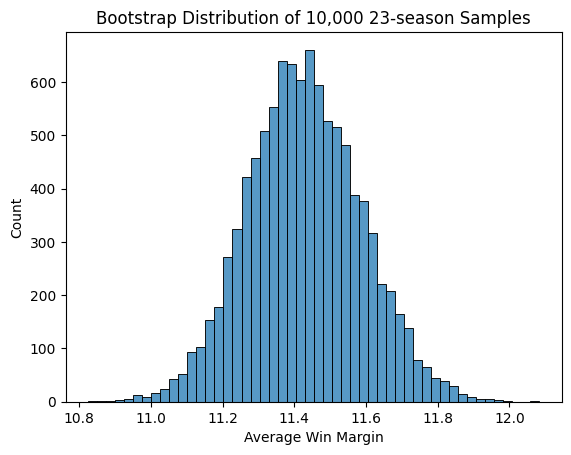

In [78]:
# Get sample means
win_margin_boot_dist = []
for i in range(10000):
	win_margin_boot_dist.append(
		# Get point estimate
		np.mean(
			# Resample
			by_season_1999_2021.sample(frac=1, replace=True)['avg_win_margin']
		)
	)

# Confirm sample means are normally distributed
g = sns.histplot(win_margin_boot_dist, bins=50)
g.set(
	xlabel="Average Win Margin",
	title="Bootstrap Distribution of 10,000 23-season Samples"
)
plt.show()

As expected, the average win margin of the bootstrap population is normally distributed. I can perform a 1-sample T-Test to test the null hypothesis. 

In [68]:
# Perform 1-sample T-Test
import pingouin

pingouin.ttest(win_margin_boot_dist, by_season_2022['avg_win_margin'].iloc[0], "left")

/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/pingouin/parametric.py:227: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")
/Volumes/develop/projects/fantasy_football_analysis/env/lib/python3.10/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,898.21071,4999,two-sided,0.0,"[11.42, 11.43]",12.702618,inf,1.0


In [67]:
by_season_2022['avg_win_margin'].iloc[0]

9.426470588235293